In this notebook I create a model that will predict whether a person does or does not have diabetes. I am using a modified diabetes.csv dataset, the original can be found on [Kaggle](https://www.kaggle.com/mathchi/diabetes-data-set).

The target column in the dataset is "Outcome". 

In [90]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

In [91]:
diabetes = pd.read_csv('diabetes.csv', sep=';')
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,NaN,148.0,72.0,35.0,0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94,28.1,0.167,21.0,0
4,0.0,NaN,40.0,35.0,168,43.1,2.288,NaN,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,NaN,180,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.0,Zero,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112,26.2,0.245,30.0,N
766,1.0,126.0,60.0,0.0,Zero,30.1,0.349,47.0,1


In [92]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,731.0,3.824897,3.369400,0.000,1.000,3.0000,6.0000,17.00
Glucose,730.0,121.152055,31.774802,0.000,99.000,117.0000,141.0000,198.00
BloodPressure,734.0,69.008174,19.496036,0.000,64.000,72.0000,80.0000,122.00
SkinThickness,734.0,20.848774,15.876665,0.000,0.000,23.0000,32.0000,99.00
BMI,733.0,31.979536,7.918709,0.000,27.400,32.0000,36.5000,67.10
DiabetesPedigreeFunction,728.0,0.472702,0.331714,0.078,0.245,0.3725,0.6245,2.42
Age,717.0,34.108787,16.119730,-1.000,24.000,29.0000,41.0000,200.00


In [93]:
diabetes.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                      object
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                      object
dtype: object

In [94]:
diabetes.Insulin.unique()

array(['0', '94', '168', 'Zero', '88', '543', '846', '175', '230', nan,
       '96', '235', '146', '115', '110', '245', '54', '192', '207', '70',
       '240', '82', '36', '23', '300', '342', '142', '128', '38', '90',
       '140', '270', '71', '125', '176', '48', '64', '228', '76', '220',
       '40', '152', '18', '135', '495', '37', '51', '100', '99', '145',
       '225', '49', '50', '92', '325', '63', '119', '204', '155', '485',
       '53', '114', '105', '285', '156', '78', '55', '130', '58', '160',
       '210', '318', '44', '190', '280', '271', '129', '120', '478', '56',
       '32', '370', '45', '194', '680', '402', '258', '375', '150', '67',
       '57', '116', '278', '122', '545', '75', '74', '182', '360', '215',
       '184', '42', '132', '148', '180', '205', '85', '231', '29', '68',
       '52', '255', '171', '73', '108', '83', '43', '167', '249', '293',
       '66', '465', '89', '158', '84', '72', '59', '81', '196', '415',
       '87', '275', '165', '579', '310', '61', '474

In [95]:
diabetes.Outcome.unique()

array(['1', '0', 'N', 'Y'], dtype=object)

Values for variable Insulin are type=object and have both Zero and 0 as values. We should turn Zero to 0 and change the variable type to numeric. Same for variable Insulin. We should transform N to 0 and Y to 1 and then change the variable type to numeric. Let's create a custom transformer for that to be able to pipeline this step when validating the result. 

In [96]:
diabetes['Insulin'] = diabetes['Insulin'].apply(lambda x: 0 if x == 'Zero' else float(x))

In [97]:
diabetes['Outcome'] = diabetes['Outcome'].apply(lambda x: 0 if x=='N' else (1 if x == 'Y' else int(x)))

<AxesSubplot:ylabel='Outcome'>

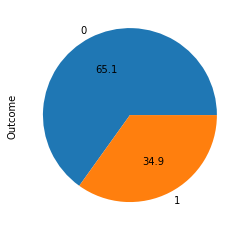

In [98]:
diabetes["Outcome"].value_counts().plot.pie(autopct = "%.1f")

<AxesSubplot:ylabel='Pregnancies'>

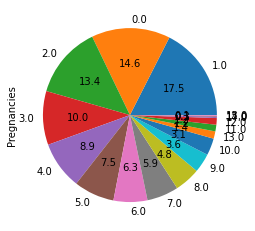

In [99]:
diabetes["Pregnancies"].value_counts().plot.pie(autopct = "%.1f")

Let's replace the 0 in all the features except pregnancies with nan's since they are obviously just missing entries

In [100]:
diabetes.iloc[:, 1:8] = diabetes.iloc[:, 1:8].replace({0 : np.nan})

In [101]:
diabetes.isnull().sum()

Pregnancies                  37
Glucose                      42
BloodPressure                69
SkinThickness               243
Insulin                     400
BMI                          46
DiabetesPedigreeFunction     40
Age                          51
Outcome                       0
dtype: int64

Let's start of with a RandomForest. In order to be able to use it, let's replace our NaNs with median values using SimpleImputer. 

Let's save our target variable under y and predictors under X and do a train test split.

In [102]:
X = diabetes.drop('Outcome', axis =1)
y = diabetes['Outcome']

In [103]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

Now we can do cross validation with 10 folds on the training set to see how the model performs in general. 

In [104]:
imputer = SimpleImputer(strategy = 'median')
clf = RandomForestClassifier(n_estimators=100)

pipeline = Pipeline(steps=[('imputer', imputer),
                           ('model', clf)
                             ])

cv_results = cross_val_score(pipeline, train_X, train_y, cv = 10)
print("Cross validation scores are:", cv_results)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))

Cross validation scores are: [0.72413793 0.79310345 0.81034483 0.82758621 0.68965517 0.84482759
 0.64912281 0.64912281 0.80701754 0.80701754]
0.76 accuracy with a standard deviation of 0.07


Now let's see how our model will perform on the data it hasn't seen so far using test data. 

In [124]:
pipeline = Pipeline(steps=[('imputer', imputer),
                           ('model', clf)
                             ])

pipeline.fit(train_X, train_y)

preds = pipeline.predict(test_X)

conf_m = confusion_matrix(test_y, preds)
precision = round(precision_score(test_y, preds)*100, 2)
recall = round(recall_score(test_y, preds)*100, 2)
f1 = round(f1_score(test_y, preds)*100, 2)
accuracy = round(accuracy_score(test_y, preds)*100, 2)
print('Confusion matrix:', conf_m)
print('Precision score:', precision)
print('Recall score:', recall)
print('F1 score:', f1)
print('Accuracy score', accuracy)

Confusion matrix: [[110  20]
 [ 28  34]]
Precision score: 62.96
Recall score: 54.84
F1 score: 58.62
Accuracy score 75.0


The accuracy of our model is not very convincing, having 30 false negatives is not good enough in case of cancer prediction. Let's try to increase the accuracy of our model by imputing NaN's based on the outcome. 

Let's fill in na's in features based on outcome, e.g. replace na's with median values in this column depending on if the Outcome is 0 or 1.

In [106]:
diabetes.head()
diabetes.isnull().sum()
diabetes.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                       int64
dtype: object

In [107]:
diabetes_features = diabetes.drop(['Outcome'], axis=1).columns
diabetes_improved = diabetes.copy()
for feature in diabetes_features:
    value_for_outcome_1 = diabetes_improved.groupby("Outcome")[feature].median()[1]
    value_for_outcome_0 = diabetes_improved.groupby("Outcome")[feature].median()[0]
    diabetes_improved.loc[(diabetes_improved["Outcome"] == 0) & (diabetes_improved[feature].isnull()), feature] = value_for_outcome_0
    diabetes_improved.loc[(diabetes_improved["Outcome"] == 1) & (diabetes_improved[feature].isnull()), feature] = value_for_outcome_1
print(diabetes_improved.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [108]:
X_improved = diabetes_improved.drop('Outcome', axis =1)
y_improved = diabetes_improved['Outcome']

In [109]:
train_X_improved, test_X_improved, train_y_improved, test_y_improved = train_test_split(X_improved, y_improved, random_state = 0)

In [110]:
kfold = KFold(n_splits = 10)
clf = RandomForestClassifier(n_estimators=100)
cv_results = cross_val_score(clf, train_X_improved, train_y_improved, cv = 10)
print("Cross validation scores are:", cv_results)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))

Cross validation scores are: [0.89655172 0.89655172 0.87931034 0.93103448 0.86206897 0.94827586
 0.85964912 0.80701754 0.9122807  0.84210526]
0.88 accuracy with a standard deviation of 0.04


In [125]:
clf.fit(train_X_improved, train_y_improved)

preds_improved = (clf.predict(test_X_improved))

conf_m_1 = confusion_matrix(test_y_improved, preds_improved)
precision_1 = round(precision_score(test_y_improved, preds_improved) * 100, 2)
recall_1 = round(recall_score(test_y_improved, preds_improved) * 100, 2)
f1_1 = round(f1_score(test_y_improved, preds_improved) * 100, 2)
accuracy_1 = round(accuracy_score(test_y_improved, preds_improved) * 100, 2)
print('Confusion matrix:', conf_m_1)
print('Precision score:', precision_1)
print('Recall score:', recall_1)
print('F1 score:', f1_1)
print('Accuracy score', accuracy_1)

Confusion matrix: [[119  11]
 [  4  58]]
Precision score: 84.06
Recall score: 93.55
F1 score: 88.55
Accuracy score 92.19


So we were able to increase performance by just changing the handling of missing values. Let's try to use a different algorithm and see if we can boost our performance even further. 

In [126]:
svm_clf = svm.SVC(kernel = 'rbf', C=1)
kfold = KFold(n_splits = 10)
cv_results = cross_val_score(svm_clf, train_X_improved, train_y_improved, cv = 10)
print("Cross validation scores are:", cv_results)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))

Cross validation scores are: [0.84482759 0.87931034 0.82758621 0.87931034 0.84482759 0.89655172
 0.78947368 0.75438596 0.84210526 0.85964912]
0.84 accuracy with a standard deviation of 0.04


In [127]:
svm_clf.fit(train_X_improved, train_y_improved)

preds_improved = (svm_clf.predict(test_X_improved))

conf_m_1 = confusion_matrix(test_y_improved, preds_improved)
precision_1 = round(precision_score(test_y_improved, preds_improved) * 100, 2)
recall_1 = round(recall_score(test_y_improved, preds_improved) * 100, 2)
f1_1 = round(f1_score(test_y_improved, preds_improved) * 100, 2)
accuracy_1 = round(accuracy_score(test_y_improved, preds_improved) * 100, 2)
print('Confusion matrix:', conf_m_1)
print('Precision score:', precision_1)
print('Recall score:', recall_1)
print('F1 score:', f1_1)
print('Accuracy score', accuracy_1)

Confusion matrix: [[114  16]
 [  8  54]]
Precision score: 77.14
Recall score: 87.1
F1 score: 81.82
Accuracy score 87.5


Since SVM is a distance based algorithm it is probably sensitive to the scale of the features. Our features currently have very diferent ranges, with e.g. max values ranging from 2.42 to 846:

In [114]:
X_improved.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.770833,121.524740,72.394531,29.054688,141.658854,32.401562,0.467436,33.882812
std,3.302574,29.938649,11.641928,8.784372,84.166770,6.726429,0.323962,15.639412
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.078000,-1.000000
25%,1.000000,100.000000,65.000000,25.000000,105.000000,27.775000,0.251000,24.000000
50%,3.000000,116.000000,72.000000,27.000000,105.000000,32.000000,0.364500,29.000000
75%,6.000000,140.000000,80.000000,32.000000,171.000000,36.225000,0.602000,40.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,200.000000


Let's standardize our features with StandardScaler.

In [115]:
X_improved.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,4.0,148.0,72.0,35.0,171.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,105.0,26.6,0.351,31.0
2,8.0,183.0,64.0,32.0,171.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,140.0,40.0,35.0,168.0,43.1,2.288,36.0


In [116]:
standard_scaler = StandardScaler()
cols = X_improved.columns
X_standardized = scaler.fit_transform(X_improved)
X_standardized = pd.DataFrame(X_standardized, columns= cols)
X_standardized.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.069436,0.884893,-0.033911,0.677247,0.348834,0.178285,0.492860,1.031221
1,-0.839539,-1.220781,-0.549625,-0.006230,-0.435834,-0.863065,-0.359648,-0.184450
2,1.281401,2.054713,-0.721530,0.335509,0.348834,-1.353986,0.631856,-0.120467
3,-0.839539,-1.087088,-0.549625,-0.689706,-0.566612,-0.639918,-0.927986,-0.824277
4,-1.142530,0.617506,-2.784388,0.677247,0.313168,1.591544,5.623350,0.135463


In [117]:
train_X_standardized, test_X_standardized, train_y_improved, test_y_improved = train_test_split(X_standardized, y_improved, random_state = 0)

In [128]:
svm_clf = svm.SVC(kernel = 'rbf', C=1)
kfold = KFold(n_splits = 10)
cv_results = cross_val_score(svm_clf, train_X_standardized, train_y_improved, cv = 10)
print("Cross validation scores are:", cv_results)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))

Cross validation scores are: [0.77586207 0.87931034 0.79310345 0.94827586 0.81034483 0.86206897
 0.87719298 0.73684211 0.85964912 0.80701754]
0.83 accuracy with a standard deviation of 0.06


In [129]:
svm_clf.fit(train_X_standardized, train_y_improved)

preds_improved = (svm_clf.predict(test_X_standardized))

conf_m_1 = confusion_matrix(test_y_improved, preds_improved)
precision_1 = round(precision_score(test_y_improved, preds_improved) * 100, 2)
recall_1 = round(recall_score(test_y_improved, preds_improved) * 100, 2)
f1_1 = round(f1_score(test_y_improved, preds_improved) * 100, 2)
accuracy_1 = round(accuracy_score(test_y_improved, preds_improved) * 100, 2)
print('Confusion matrix:', conf_m_1)
print('Precision score:', precision_1)
print('Recall score:', recall_1)
print('F1 score:', f1_1)
print('Accuracy score', accuracy_1)

Confusion matrix: [[119  11]
 [ 15  47]]
Precision score: 81.03
Recall score: 75.81
F1 score: 78.33
Accuracy score 86.46


This didn't really improve our accuracy score, in fact it has brought it down. Let's now try normalizing our data. 

In [120]:
min_max_scaler = MinMaxScaler()
cols = X_improved.columns
X_normalized = min_max_scaler.fit_transform(X_improved)
X_normalized = pd.DataFrame(X_normalized, columns= cols)
X_normalized.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.235294,0.675325,0.456522,0.304348,0.188702,0.314928,0.234415,0.253731
1,0.058824,0.266234,0.391304,0.239130,0.109375,0.171779,0.116567,0.159204
2,0.470588,0.902597,0.369565,0.271739,0.188702,0.104294,0.253629,0.164179
3,0.058824,0.292208,0.391304,0.173913,0.096154,0.202454,0.038002,0.109453
4,0.000000,0.623377,0.108696,0.304348,0.185096,0.509202,0.943638,0.184080


In [121]:
train_X_normalized, test_X_normalized, train_y_improved, test_y_improved = train_test_split(X_normalized, y_improved, random_state = 0)

In [122]:
svm_clf = svm.SVC(kernel = 'rbf', C=1)
kfold = KFold(n_splits = 10)
cv_results = cross_val_score(svm_clf, train_X_normalized, train_y_improved, cv = 10)
print("Cross validation scores are:", cv_results)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))

Cross validation scores are: [0.74137931 0.82758621 0.74137931 0.86206897 0.81034483 0.82758621
 0.80701754 0.70175439 0.77192982 0.80701754]
0.79 accuracy with a standard deviation of 0.05


In [123]:
svm_clf.fit(train_X_normalized, train_y_improved)

preds_improved = (svm_clf.predict(test_X_normalized))

conf_m_1 = confusion_matrix(test_y_improved, preds_improved)
precision_1 = round(precision_score(test_y_improved, preds_improved) * 100, 2)
recall_1 = round(recall_score(test_y_improved, preds_improved) * 100, 2)
f1_1 = round(f1_score(test_y_improved, preds_improved) * 100, 2)
accuracy_1 = round(accuracy_score(test_y_improved, preds_improved) * 100, 2)
print('Confusion matrix:', conf_m_1)
print('Precision score:', precision_1)
print('Recall score:', recall_1)
print('F1 score:', f1_1)
print('Accuracy score', accuracy_1)

Confusion matrix: [[117  13]
 [ 28  34]]
Precision score: 72.34
Recall score: 54.84
F1 score: 62.39
Accuracy score 78.65


Normalization reduced our accuracy even lower, so far the best results have been achieved using RandomForestClassifier with unscaled data. 